# Recap of HW2, HW3 is below

In [1]:
import numpy as np
import math
from matplotlib import pyplot
%matplotlib inline
from scipy.io import loadmat
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
__tab_colors = ["hotpink", "dodgerblue", "coral", "silver", "darkcyan"]
__color_index = -1
def next_color():
    global __color_index
    __color_index += 1
    index = __color_index%len(__tab_colors)
    return __tab_colors[index]
def reset_color():
    global __color_index
    __color_index = -1

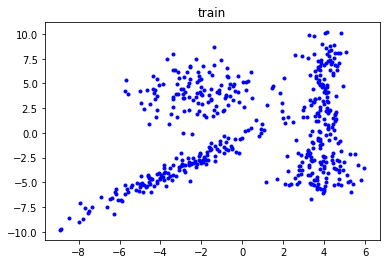

In [3]:
# fonction pour lire un fichier
def loadfile(strfile):
    fileo = open(strfile, "r") 
    y = []
    for line in fileo: 
        y.append(list(map(float, line.split())))
    fileo.close()
    return np.array(y)
    
# load trains
emTrain = loadfile("EMGaussian.data")
emTest = loadfile("EMGaussian.test")

def show(data, name, show=True):
    dataT = np.transpose(data)
    pyplot.scatter(dataT[0], dataT[1], c = "blue", marker = '.')
    pyplot.title(name)
    if show:
        pyplot.show()
show(emTrain, "train")

In [4]:
def K_Means(data, K):
    n = data.shape[0]
    
    # initialise at K random cluster
    index = np.arange(n)
    np.random.shuffle(index)
    mu = data[index[0:K]]

    oldC = np.zeros(n)
    while "The algorithm has not converged":
        # assign each point to the closest centroid
        newC = np.zeros(n)
        Cdic = [[] for k in range(K)]
        for i in range(n):
            clus = np.argmin(np.linalg.norm(mu - data[i], axis = 1))
            newC[i] = clus
            Cdic[clus].append(i)
        # recompute centroid
        for k in range(K):
            mu[k] = (1./len(Cdic[k]))*np.sum(data[Cdic[k]], axis=0)
        
        # if it has converged
        if (newC == oldC).all():
            break
        oldC = newC
    return Cdic, mu

In [5]:
def show_K_colors(data, name, K, clusters, centroids, axe):
    reset_color()
    for k in range(K):
        dataT = np.transpose(data[clusters[k]])
        c = next_color()
        axe.scatter(dataT[0], dataT[1], c=c, marker = '.')
        axe.scatter(centroids[k][0], centroids[k][1], c="black", marker = 'o', s=50)
        axe.set_title(name)

In [6]:
def show_2x2(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        clusters, centroids = K_Means(data, K)
        show_K_colors(data, "K="+str(K), K, clusters, centroids, axe)
    pyplot.suptitle("K Means on "+name)
    pyplot.show()

In [9]:
def show_2x2_random_4(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        clusters, centroids = K_Means(data, 4)
        show_K_colors(data, "K="+str(4), 4, clusters, centroids, axe)
    pyplot.suptitle("K Means K=4, "+name)
    pyplot.show()

In [11]:
def EM_algorithm_isotropic(data, K):
    #initialisation with K_Means
    n, d = data.shape
    # initialise mu
    clusters, oldmu = K_Means(data, K)
    
    # initialise pi
    pi = np.array([len(clusters[k]) for k in range(K)])
    pi = pi / np.sum(pi)
    
    # initialise isotropic sigma_k = v_k Id
    vsigma = np.ones((K))
    Id = np.identity(d)
    # initialise q
    q = np.zeros((n,K))
    while "The algorithm has not converged":
        # E step
        normal = np.array([multivariate_normal.pdf(data, oldmu[k], vsigma[k]*Id) for k in range(K)])
        denom = np.dot(normal.T, pi)
        denom = np.broadcast_to(denom, (K,n)).T
        pimul = np.broadcast_to(pi, (n,K))
        mul = pimul/denom
        q = (mul*normal.T)

        # M step
        # mu computation
        num = np.dot(q.T, data)
        denom = np.broadcast_to(np.sum(q, axis=0), (d,K)).T
        newmu = num/denom
        
        # pi computation
        pi = np.sum(q, axis=0) / np.sum(q)
        
        # sigma computation
        # numerator
        gdata = np.broadcast_to(data, (K,n,d))
        gmu = np.broadcast_to(newmu, (n,K,d)).transpose(1,0,2)
        prod = gdata-gmu
        num = np.einsum('...a,...b', prod, prod)
        num = np.einsum('...ii', num).transpose(1,0)
        num = np.einsum('ab,ab->b', num, q)
        # denominator
        denom = np.sum(q, axis=0)
        vsigma = num/denom
        
        # sigma test
        for k in range(K):
            susuk = 0
            for i in range(n):
                susuk += np.linalg.norm(data[i]-newmu[k])**2 * q[i,k]
            vsigma[k] = susuk / (d*np.sum(q[:,k]))
            
        if (np.linalg.norm(newmu - oldmu)) < 0.01:
            break
        oldmu = newmu
    return vsigma,newmu,pi,q

vsigma,mu,pi,q = EM_algorithm_isotropic(emTrain, 4)

In [12]:
def show_K_colors_ellipse_isotropic(data, name, K, clusters, mu, vsigma, axe):
    reset_color()
    for k in range(K):
        # Ellipse part, here 90%
        s = -2*np.log(1-0.90)
        theta = 90
        w = 2*np.sqrt(s*vsigma[k])
        h = w
        ell = Ellipse(xy=(mu[k][0], mu[k][1]),
                      width=w, height=h,
                      angle=theta)
        ell.set_color("black")
        ell.set_facecolor('none')
        axe.add_artist(ell)
        
        # scatter
        dataT = np.transpose(data[clusters[k]])
        axe.scatter(dataT[0], dataT[1], c=next_color(), marker = '.')
        axe.scatter(mu[k][0], mu[k][1],c="black", marker = 'o', s=50)
        axe.set_title(name)
        
        
def show_2x2_EM_isotropic(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        vsigma,mu,pi,q = EM_algorithm_isotropic(data, K)
        amax = np.argmax(q, axis=1)
        clusters = [np.argwhere(amax==k).reshape(-1) for k in range(K)]
        show_K_colors_ellipse_isotropic(data, "K="+str(K), K, clusters, mu, vsigma, axe)

    pyplot.suptitle("EM isotropic, "+name)
    pyplot.show()
    

In [17]:
def EM_algorithm(data, K):
    #initialisation with K_Means
    n, d = data.shape
    
    # initialise mu
    clusters, oldmu = K_Means(data, K)
    
    # initialise pi
    pi = np.array([len(clusters[k]) for k in range(K)])
    pi = pi / np.sum(pi)
    
    # initialise sigma
    sigma = np.array([np.identity(d) for k in range(K)])
    
    # initialise q
    q = np.zeros((n,K))
    while "The algorithm has not converged":
        # E step
        normal = np.array([multivariate_normal.pdf(data, oldmu[k], sigma[k]) for k in range(K)])
        denom = np.dot(normal.T, pi)
        denom = np.broadcast_to(denom, (K,n)).T
        pimul = np.broadcast_to(pi, (n,K))
        mul = pimul/denom
        q = (mul*normal.T)

        # M step
        # mu computation
        num = np.dot(q.T, data)
        denom = np.broadcast_to(np.sum(q, axis=0), (d,K)).T
        newmu = num/denom
        
        # pi computation
        pi = np.sum(q, axis=0) / np.sum(q)

        # sigma computation
        # numerator
        gdata = np.broadcast_to(data, (K,n,d))
        gmu = np.broadcast_to(newmu, (n,K,d)).transpose(1,0,2)
        prod = gdata-gmu
        num = np.einsum('...a,...b', prod, prod).transpose(2,3,1,0)
        num = np.einsum('...ab,ab->...b', num, q).transpose(2,1,0)
        # denominator
        denom = np.broadcast_to(np.sum(q, axis=0), (d,d,K)).T
        
        sigma = num/denom
        
        if (np.linalg.norm(newmu - oldmu)) < 0.01:
            break
        oldmu = newmu
    
    return sigma,newmu,pi,q

In [18]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

In [19]:
def show_K_colors_ellipse(data, name, K, clusters, mu, sigma, axe):
    reset_color()
    for k in range(K):
        # Ellipse part, here 90%
        s = -2*np.log(1-0.90)
        vals, vecs = eigsorted(s*sigma[k])
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        w, h = 2 * np.sqrt(vals)
        ell = Ellipse(xy=(mu[k][0], mu[k][1]),
                      width=w, height=h,
                      angle=theta)
        ell.set_color("black")
        ell.set_facecolor('none')
        axe.add_artist(ell)
        
        # scatter
        dataT = np.transpose(data[clusters[k]])
        axe.scatter(dataT[0], dataT[1], c=next_color(), marker = '.')
        axe.scatter(mu[k][0], mu[k][1],c="black", marker = 'o', s=50)
        axe.set_title(name)
        
        
def show_2x2_EM(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        sigma,mu,pi,q = EM_algorithm(data, K)
        amax = np.argmax(q, axis=1)
        clusters = [np.argwhere(amax==k).reshape(-1) for k in range(K)]
        show_K_colors_ellipse(data, "K="+str(K), K, clusters, mu, sigma, axe)

    pyplot.suptitle("EM algorithm, "+name)
    pyplot.show()
    

In [691]:
def show_2x2_4_EM(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        sigma,mu,pi,q = EM_algorithm(data, 4)
        amax = np.argmax(q, axis=1)
        clusters = [np.argwhere(amax==k).reshape(-1) for k in range(4)]
        show_K_colors_ellipse(data, "K="+str(4), 4, clusters, mu, sigma, axe)
    pyplot.suptitle("EM algorithm, "+name)
    pyplot.show()

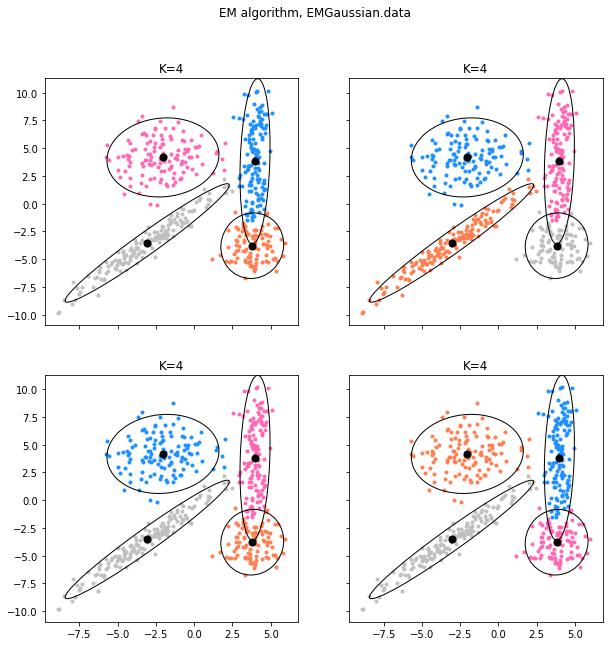

In [692]:
show_2x2_4_EM(emTrain, "EMGaussian.data")

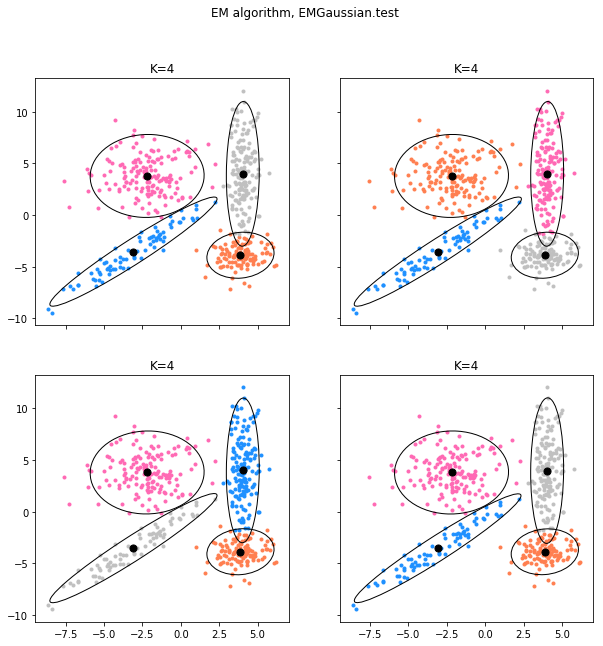

In [24]:
show_2x2_4_EM(emTest, "EMGaussian.test")

In [580]:
def log_likelihood(data, mu, sigma, q, pi, K):
    normal = np.array([multivariate_normal.pdf(data, mu[k], sigma[k]) for k in range(K)])
    lognormal = np.log(normal)    
    sum1 = np.einsum("ij,ij", q.T, lognormal)
    sum2 = np.einsum("ij,j->", q, pi) 
    return sum1 + sum2

def log_likelihood_all(data, K):
    N, d = data.shape
    vsigma,mu,pi,q = EM_algorithm_isotropic(data, K)
    sigma = np.array([v*np.identity(2) for v in vsigma])
    l = log_likelihood(data, mu, sigma, q, pi, K)/N
    print("Isotropic: ", l)
    
    sigma,mu,pi,q = EM_algorithm(data, K)
    l = log_likelihood(data, mu, sigma, q, pi, K)/N
    print("General: ", l)

In [581]:
print("EM Data")
log_likelihood_all(emTrain, 4)
print()
print("EM Test")
log_likelihood_all(emTest, 4)

EM Data
Isotropic:  -3.8561463381032652
General:  -3.1120452057994563

EM Test
Isotropic:  -3.704050989221913
General:  -3.1831278649073704


# HW3

In [582]:
ntype = np.longdouble

## Sum tricks

In [388]:
def sum_tricks(T):
    Tlog = np.log(T)
    a_star = np.max(Tlog)
    return np.exp(a_star + np.log(np.sum(np.exp(Tlog-a_star))))

def prod_tricks(T):
    Tlog = np.log(T)
    return np.exp(Tlog.sum())

In [355]:
tab = 1/np.power(2, np.arange(10000, 10050, dtype=ntype))
print("Very small floats tab:")
print(tab, "\n")

s = 0
for t in tab:
    s += t
print("Naive sum:")
print(t, "\n")

print("Numpy sum:")
print(np.sum(tab), "\n")

print("Tricks sum:")
print(sum_tricks(tab), "\n")

Very small floats tab:
[5.01237275e-3011 2.50618637e-3011 1.25309319e-3011 6.26546594e-3012
 3.13273297e-3012 1.56636648e-3012 7.83183242e-3013 3.91591621e-3013
 1.95795811e-3013 9.78979053e-3014 4.89489526e-3014 2.44744763e-3014
 1.22372382e-3014 6.11861908e-3015 3.05930954e-3015 1.52965477e-3015
 7.64827385e-3016 3.82413692e-3016 1.91206846e-3016 9.56034231e-3017
 4.78017116e-3017 2.39008558e-3017 1.19504279e-3017 5.97521394e-3018
 2.98760697e-3018 1.49380349e-3018 7.46901743e-3019 3.73450871e-3019
 1.86725436e-3019 9.33627179e-3020 4.66813589e-3020 2.33406795e-3020
 1.16703397e-3020 5.83516987e-3021 2.91758493e-3021 1.45879247e-3021
 7.29396233e-3022 3.64698117e-3022 1.82349058e-3022 9.11745292e-3023
 4.55872646e-3023 2.27936323e-3023 1.13968161e-3023 5.69840807e-3024
 2.84920404e-3024 1.42460202e-3024 7.12301009e-3025 3.56150505e-3025
 1.78075252e-3025 8.90376261e-3026] 

Naive sum:
8.903762614676317372e-3026 

Numpy sum:
1.0024745498412895115e-3010 

Tricks sum:
1.0024745498412896

In [659]:
tab = 1/np.power(2, np.arange(500, 510, dtype=ntype))
print("Very small floats tab:")
print(tab, "\n")

s = 1
for t in tab:
    s *= t
print("Naive prod:")
print(t, "\n")

print("Numpy prod:")
print(np.prod(tab), "\n")

print("Tricks prod:")
print(prod_tricks(tab), "\n")

Very small floats tab:
[3.05493636e-151 1.52746818e-151 7.63734091e-152 3.81867045e-152
 1.90933523e-152 9.54667614e-153 4.77333807e-153 2.38666903e-153
 1.19333452e-153 5.96667258e-154] 

Naive prod:
5.9666725849601653946e-154 

Numpy prod:
2.0122033848361334357e-1519 

Tricks prod:
2.0122033848361331689e-1519 



** Comment **: We can notice that numpy do a good job. Nevertheless, I will use the trick.

In [660]:
def alpha_beta_recursion(data, K, A, sigma, mu, pi0):
    T, d = data.shape
    
    # computation of alpha
    alpha = np.zeros((T,K), dtype=ntype)
    alpha[0] = pi0

    for t in range(1, T):
        p_ut_G_qt = np.array([multivariate_normal.pdf(data[t], mu[k], sigma[k]) for k in range(K)], dtype=ntype)
        for k in range(K):
            p_qt_G_qt_minus_1 = A[k, :]
            insum = sum_tricks([prod_tricks([p_qt_G_qt_minus_1[r], alpha[t-1][r]]) for r in range(K)])
            alpha[t][k] = prod_tricks([insum,p_ut_G_qt[k]])
       

    # computation of beta
    beta = np.zeros((T,K), dtype=ntype)
    beta[T-1] = 1 # array of 1 thanks numpy

    for t in range(T-2, -1, -1):
        p_ut_plus_1_G_qt_plus_1 = np.array([multivariate_normal.pdf(data[t+1], mu[k], sigma[k]) for k in range(K)], dtype=ntype)
        
        for k in range(K):
            p_qt_plus_1_G_qt = A[:, k]
            ta = p_ut_plus_1_G_qt_plus_1
            tb = p_qt_plus_1_G_qt
            tc = beta[t+1]
            beta[t][k] = sum_tricks([prod_tricks([ta[r],tb[r]*tc[r]]) for r in range(K)])

    # computation of p(u1, ..., un)
    pu = sum_tricks([prod_tricks([alpha[0][r], beta[0][r]]) for r in range(K)])    

    # computation of p(qt | u1, ..., uT) = p1
    p1 = np.zeros((T,K), dtype=ntype)
    for t in range(T):
        for k in range(K):
            p1[t][k] = prod_tricks([alpha[t][k], beta[t][k], 1 / pu])

    # computation of p(qt,qt+1 | u1, ..., uT) = p2
    p2 = np.zeros((T-1,K, K), dtype=ntype)
    for t in range(T-1):
        p_ut_plus_1_G_qt_plus_1 = np.array([multivariate_normal.pdf(data[t+1], mu[k], sigma[k]) for k in range(K)], dtype=ntype)
        for i in range(K):
            for j in range(K):
                # p2[t][i][j] here is p2(qt, qt+1 | u1, ..., uT) when qt=i and qt+1=j
                # p(qt+1 = i| qt = j) = A[i][j] 
                p2[t][i][j] = prod_tricks([1/pu,alpha[t][i],beta[t+1][j],A[i][j],p_ut_plus_1_G_qt_plus_1[j]])
    
    return p1, p2, pu

In [712]:
def HMM(data):
    T, d = data.shape
    K = 4
    A = np.ones((K,K), dtype=ntype)/K
    sigma,mu,pi,q = EM_algorithm(data, K)
    
    pi0 = q[0]
    niter = 5
    for itt in range(niter):
        ## E step
        gamma, xhi, pu = alpha_beta_recursion(data, K, A, sigma, mu, pi0)
        
        ## M step 
        # pi update
        for k in range(K):
            #pi[k] = gamma[0][k]/np.sum(gamma[0])
            pi0[k] = prod_tricks([gamma[0][k], 1/sum_tricks(gamma[0])])

        # A update
        for i in range(K):
            for j in range(K):
                A[i][j] = sum_tricks([xhi[t][j][i] for t in range(T-1)])/ sum_tricks([xhi[t][j][l] for t in range(T-1) for l in range(K)])
        
        # mu update
        for k in range(K):
            # no sum tricks because data can be < 0
            mu[k] = np.sum([gamma[t][k]*data[t] for t in range(T)], axis=0) /np.sum([gamma[t][k] for t in range(T)], axis=0)

        # sigma update
        for k in range(K):
            num = np.sum([gamma[t][k] * np.outer(data[t]-mu[k], data[t] - mu[k]) for t in range(T)], axis=0)
            sigma[k] = num / sum_tricks(gamma[:,k])
        

    return A, pi0, sigma, mu, pu

In [713]:
def inference_alg(data, A, pi0, sigma, mu):
    T, d = data.shape
    K = 4
    # computation of alpha
    alpha = np.zeros((T,K), dtype=ntype)
    alpha[0] = pi0
    
    amax = np.zeros((T,K))
    
    for t in range(1, T):
        p_ut_G_qt = np.array([multivariate_normal.pdf(data[t], mu[k], sigma[k]) for k in range(K)], dtype=ntype)
        for k in range(K):
            p_qt_G_qt_minus_1 = A[k, :]
            tab = [prod_tricks([p_qt_G_qt_minus_1[r], alpha[t-1][r]]) for r in range(K)]
            insum = np.max(tab)
            amax[t][k] = np.argmax(tab)
            alpha[t][k] = prod_tricks([insum,p_ut_G_qt[k]])
       

    # computation of beta
    beta = np.zeros(T, dtype =int)
    beta[T-1] = np.argmax(alpha[T-1]) # array of 1 thanks numpy

    for t in range(T-2, -1, -1):
        beta[t] = amax[t][beta[t+1]]
        
    return beta

In [714]:
def show_HMM(data, name):
    f, axes = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,5))
    axe = axes
    K = 4
    A, pi0, sigma, mu, _ = HMM(data)
    clusters = inference_alg(data, A, pi0, sigma, mu)
    clusters = [np.argwhere(clusters==k).reshape(-1) for k in range(4)]
    show_K_colors_ellipse(data, "K="+str(K) + " HMM model", K, clusters, mu, sigma, axe)

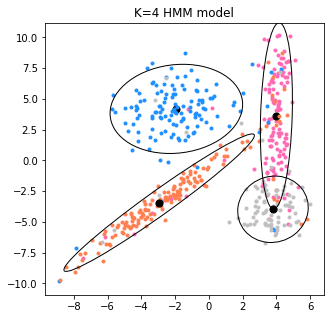

In [715]:
show_HMM(emTrain, "EMGaussian.data")

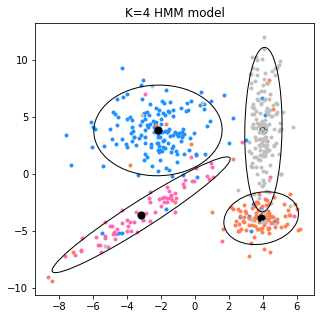

In [716]:
show_HMM(emTest, "EMGaussian.test")

In [717]:
def log_likelihood(pu):
    return np.log(pu)

def log_likelihood_all(data, name):
    T, d = data.shape
    A, pi0, sigma, mu, pu = HMM(data)
    l = log_likelihood(pu) / T
    print("Loglikelihood of "+ name + ":", l)

In [718]:
log_likelihood_all(emTrain, "train")

Loglikelihood of train: -3.882245608107197875


In [719]:
log_likelihood_all(emTest, "test")

Loglikelihood of test: -3.8950270985991434249
